In [248]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from pandas import DataFrame
from math import sqrt

In [249]:
# The path to our CSV file
file = "../data/csv/Gold_Data.csv"
df = pd.read_csv(file)
df.head()

,Business_Week,Gold_Change,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Date,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,...,USD_Change,USD_Settle,USD_Volume,USD_Wave,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,ZAR_Volume,ZAR_Wave,ZAR_Prev. Day Open Interest
0,"[2006-06-07, 2006-06-13]",0.0,602.80,324.800000,189517.8,2006-06-13,382474.0,30916.0,103211.0,42587.0,...,1.760,85.7620,7364.2,NaN,38753.4,0.0760,6.7790,65.00,NaN,2332.40
1,"[2006-06-14, 2006-06-20]",0.0,570.50,78.400000,191302.8,2006-06-20,390281.0,30963.0,94632.0,47440.0,...,0.013,86.2112,772.6,NaN,37679.6,0.1175,6.9283,45.00,NaN,2276.80
2,"[2006-06-21, 2006-06-27]",0.0,584.18,51.800000,189599.0,2006-06-27,384321.0,32287.0,91042.0,48449.0,...,0.340,86.0000,5056.2,NaN,23433.4,0.1715,7.4125,359.25,NaN,2395.75
3,"[2006-06-28, 2006-07-04]",0.0,594.40,31923.666667,297778.0,2006-07-03,392868.0,30452.0,92545.0,48087.0,...,-1.300,85.2640,2935.2,NaN,19682.8,-0.2920,7.1685,35.60,NaN,2007.00
4,"[2006-07-05, 2006-07-11]",0.0,634.00,43180.200000,253799.8,2006-07-11,427008.0,27624.0,104213.0,54509.0,...,0.230,85.0220,2823.0,NaN,19415.6,0.0960,7.1820,186.20,NaN,2227.00


In [250]:
#new = old.filter(['A','B','D'], axis=1)

df1 = df.filter(['Date','Gold_Settle','Open Interest','Money Manager Shorts', 'Money Manager Longs', 'Producer/Merchant/Processor/User Longs', 'Producer/Merchant/Processor/User Shorts'], axis=1)

In [251]:
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

In [252]:
df1.head()

,Gold_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Date,,,,,,
2006-06-13,602.80,382474.0,30916.0,103211.0,42587.0,128892.0
2006-06-20,570.50,390281.0,30963.0,94632.0,47440.0,126992.0
2006-06-27,584.18,384321.0,32287.0,91042.0,48449.0,121890.0
2006-07-03,594.40,392868.0,30452.0,92545.0,48087.0,122568.0
2006-07-11,634.00,427008.0,27624.0,104213.0,54509.0,130618.0


In [253]:
df1.corr()

,Gold_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Gold_Settle,1.000000,0.713448,0.029547,0.345678,0.338226,0.324827
Open Interest,0.713448,1.000000,0.034981,0.657985,0.284606,0.408501
Money Manager Shorts,0.029547,0.034981,1.000000,-0.444338,-0.286264,-0.706906
Money Manager Longs,0.345678,0.657985,-0.444338,1.000000,-0.029830,0.619795
Producer/Merchant/Processor/User Longs,0.338226,0.284606,-0.286264,-0.029830,1.000000,0.454285
Producer/Merchant/Processor/User Shorts,0.324827,0.408501,-0.706906,0.619795,0.454285,1.000000


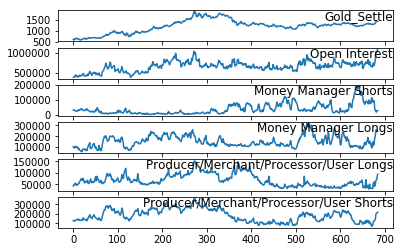

In [254]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [256]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.025239   0.000000   0.158664   0.181376   0.110468   0.206973  0.000000
2   0.000000   0.011063   0.158911   0.148317   0.149656   0.200634  0.010690
3   0.010690   0.002617   0.165892   0.134482   0.157804   0.183612  0.018676
4   0.018676   0.014729   0.156217   0.140274   0.154881   0.185874  0.049619
5   0.049619   0.063109   0.141308   0.185238   0.206740   0.212732  0.062903


In [257]:

# split into train and test sets
values = reframed.values
n_train_days = int(len(df1)*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(548, 1, 6) (548,) (136, 1, 6) (136,)


Train on 548 samples, validate on 136 samples
Epoch 1/125
 - 4s - loss: 0.4899 - val_loss: 0.5457
Epoch 2/125
 - 0s - loss: 0.4236 - val_loss: 0.4785
Epoch 3/125
 - 0s - loss: 0.3636 - val_loss: 0.4143
Epoch 4/125
 - 0s - loss: 0.3105 - val_loss: 0.3514
Epoch 5/125
 - 0s - loss: 0.2623 - val_loss: 0.2884
Epoch 6/125
 - 0s - loss: 0.2183 - val_loss: 0.2261
Epoch 7/125
 - 0s - loss: 0.1818 - val_loss: 0.1661
Epoch 8/125
 - 0s - loss: 0.1543 - val_loss: 0.1114
Epoch 9/125
 - 0s - loss: 0.1401 - val_loss: 0.0699
Epoch 10/125
 - 0s - loss: 0.1370 - val_loss: 0.0509
Epoch 11/125
 - 0s - loss: 0.1384 - val_loss: 0.0457
Epoch 12/125
 - 0s - loss: 0.1385 - val_loss: 0.0469
Epoch 13/125
 - 0s - loss: 0.1370 - val_loss: 0.0507
Epoch 14/125
 - 0s - loss: 0.1349 - val_loss: 0.0534
Epoch 15/125
 - 0s - loss: 0.1325 - val_loss: 0.0536
Epoch 16/125
 - 0s - loss: 0.1304 - val_loss: 0.0525
Epoch 17/125
 - 0s - loss: 0.1286 - val_loss: 0.0513
Epoch 18/125
 - 0s - loss: 0.1269 - val_loss: 0.0507
Epoch 19/

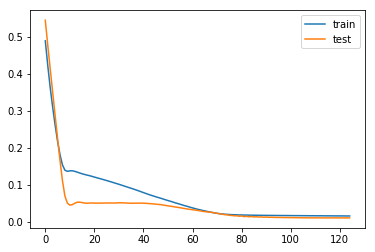

In [258]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=125, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [259]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50)                11400     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [260]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 17.083


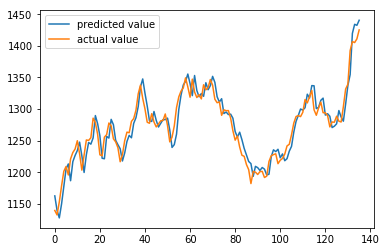

In [261]:
pyplot.plot(inv_yhat, label="predicted value")
pyplot.plot(inv_y, label="actual value")
pyplot.legend()
pyplot.show()

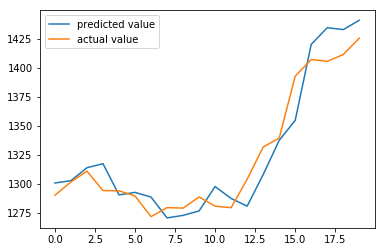

In [262]:
pyplot.plot(inv_yhat[-20:], label="predicted value")
pyplot.plot(inv_y[-20:], label="actual value")
pyplot.legend()
pyplot.show()

In [266]:
inv_yhat[len(inv_yhat)-1]

1440.7189